In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
print(os.getcwd())  # Esto imprime el directorio actual

c:\Users\rey_d\Documents\GitHub\An-lisis-de-inversion-inmobiliario\notebooks


In [3]:
import os

# Cambiar el directorio de trabajo al nivel superior
os.chdir('..')

# Verificar dónde estás ahora
print("Directorio actual:", os.getcwd())

Directorio actual: c:\Users\rey_d\Documents\GitHub\An-lisis-de-inversion-inmobiliario


In [4]:
df = pd.read_csv('data/Valencia_limpio.csv', sep=',')
df.head(2)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,days_rented
0,922483078848880362,https://www.airbnb.com/rooms/922483078848880362,20250315152909,2025-03-15,city scrape,piso acogedor,This place has a strategic location: a 5-minut...,Sin información,https://a0.muscache.com/pictures/7ace9e77-5619...,20512920,...,4.56,Sin datos,f,1,1,0,0,0.46,Valencia,288
1,968111902707427537,https://www.airbnb.com/rooms/968111902707427537,20250315152909,2025-03-16,city scrape,#2 Soho By The Sea. Beach studio,Welcome to our unique studio in the heart of C...,Sin información,https://a0.muscache.com/pictures/9fe7cdd9-2ad9...,512484841,...,4.67,Sin datos,f,5,5,0,0,1.60,Valencia,185


In [5]:
df_delincuencia = pd.read_csv('data/crimenValencia.csv', sep=';')
df_delincuencia.head(2)

,Año,Parámetro,Denuncias
0,2023,Agresión sexual con penetración,14.0
1,2023,Homicidios dolosos y asesinatos consumados,2.0


In [6]:
df_inmobiliario = pd.read_csv('data/valencia_vivienda_limpio.csv', sep=',')
df_inmobiliario.head(2)

,Año,Periodo,Precio Valencia,Precio España,city
0,2007,Trimestre 1,1988.70,1790.07,Valencia
1,2007,Trimestre 2,2077.27,1790.07,Valencia


### EDA

In [7]:
#calcular el ROI -> retorno de la inversión 

# --- LIMPIEZA Y PREPARACIÓN DE DATOS ---

# Limpiar columna de precio por metro cuadrado (quitar símbolos, convertir a float)
df_inmobiliario['Precio Valencia'] = (
    df_inmobiliario['Precio Valencia']
    .replace('[\€,]', '', regex=True)
    .astype(float)
)

# Limpiar columna de price en listings si existe (puede tener formato tipo "$100.00" o "100,00 €")
if 'price' in df.columns:
    df['price'] = (
        df['price']
        .astype(str)
        .replace('[\€,]', '', regex=True)
        .str.replace(',', '')
        .astype(float)
    )
else:
    print("⚠️ La columna 'price' no se encuentra en Valencia_limpio.csv")

# --- CALCULAR INGRESO ANUAL ESTIMADO POR PROPIEDAD ---
# Suponiendo que 'days_rented' indica cuántos días al año se alquila la propiedad
df['annual_income'] = df['price'] * df['days_rented']

# --- OBTENER PRECIO MEDIO POR M² EN VALENCIA ---
# Vamos a tomar el último año disponible
ultimo_anio = df_inmobiliario['Año'].max()
precio_m2_valencia = df_inmobiliario[df_inmobiliario['Año'] == ultimo_anio]['Precio Valencia'].mean()

# Suposición: tamaño promedio de vivienda
average_m2 = 70
df['estimated_property_value'] = precio_m2_valencia * average_m2

# --- CALCULAR ROI BRUTO ---
df['ROI (%)'] = (df['annual_income'] / df['estimated_property_value']) * 100

# --- OPCIONAL: CALCULAR ROI NETO CON GASTOS ESTIMADOS ---
gastos_anuales = 3000
df['net_annual_income'] = df['annual_income'] - gastos_anuales
df['Net ROI (%)'] = (df['net_annual_income'] / df['estimated_property_value']) * 100

# --- MOSTRAR RESULTADOS ---
# Mostrar las primeras filas
print(df[['name', 'price', 'days_rented', 'annual_income', 'estimated_property_value', 'ROI (%)', 'Net ROI (%)']].head())


                                  name  price  days_rented  annual_income  \
0                        piso acogedor  143.0          288        41184.0   
1     #2 Soho By The Sea. Beach studio  109.0          185        20165.0   
2  #3 Soho By The Sea. Beach apartment  120.0          193        23160.0   
3     #1 Soho By The Sea. Beach studio  109.0          193        21037.0   
4     Beach, Sun＆Fun  in Valencia 3bdr  134.0           49         6566.0   

   estimated_property_value    ROI (%)  Net ROI (%)  
0             105633.423037  38.987660    36.147650  
1             105633.423037  19.089602    16.249592  
2             105633.423037  21.924879    19.084869  
3             105633.423037  19.915098    17.075088  
4             105633.423037   6.215836     3.375825  


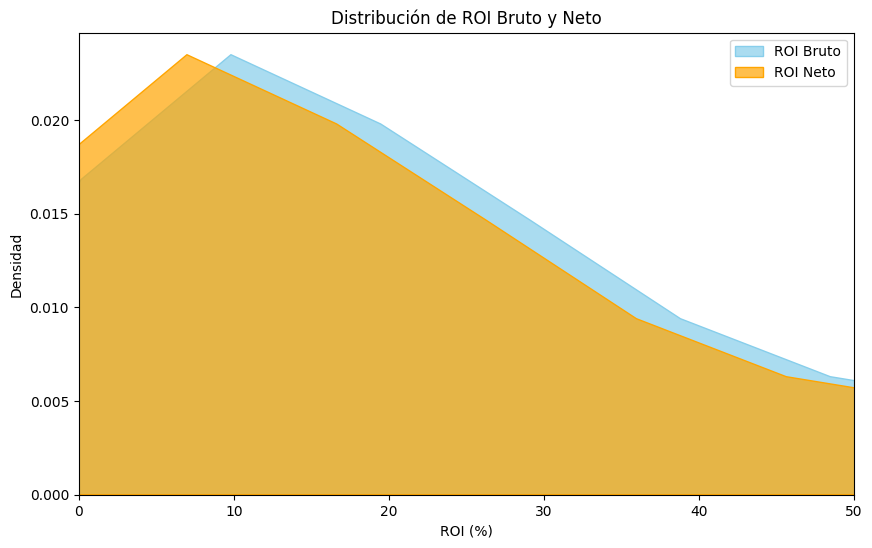

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df['ROI (%)'], fill=True, label='ROI Bruto', color='skyblue', alpha=0.7)
sns.kdeplot(df['Net ROI (%)'], fill=True, label='ROI Neto', color='orange', alpha=0.7)
plt.xlim(0, 50)
plt.xlabel('ROI (%)')
plt.ylabel('Densidad')
plt.title('Distribución de ROI Bruto y Neto')
plt.legend()
plt.show()


📊 Conclusión sobre la Distribución del ROI Bruto y Neto en Valencia

El gráfico muestra la distribución de densidad del ROI Bruto (en azul claro) y el ROI Neto (en naranja) de propiedades en alquiler en Valencia. Las curvas reflejan la frecuencia relativa de distintas tasas de retorno en el conjunto de datos.
✅ Principales observaciones:

- ROI promedio moderado:
La mayor densidad de propiedades se concentra entre el 8% y el 20% de ROI, lo que indica que la mayoría de las viviendas generan retornos en ese rango.

Diferencia entre bruto y neto es consistente:
La diferencia entre ROI bruto y neto es visible pero relativamente pequeña y uniforme. Esto sugiere que los gastos estimados (como mantenimiento, impuestos, etc.) no alteran drásticamente la rentabilidad para la mayoría de las propiedades. Gastos fijos anuales de 3000€.

- ROI alto es menos frecuente:
Propiedades con un ROI superior al 30% son menos comunes, lo cual es lógico, ya que generalmente implican un mayor riesgo, precios de adquisición más bajos o una ocupación muy alta.

El ROI neto sigue de cerca al bruto:
Esto indica que, aunque los costos afectan la rentabilidad, las propiedades en Valencia pueden seguir siendo rentables incluso después de considerar los gastos operativos.

🧠 Interpretación general:

Invertir en propiedades de alquiler en Valencia ofrece un retorno razonable, con la mayoría de los inmuebles generando entre un 8% y un 20% anual neto, lo cual es competitivo frente a otros tipos de inversión. Además, la diferencia estrecha entre ROI bruto y neto sugiere una estructura de costos operativos bastante estable o eficiente.

In [12]:
# ROI por barrio
# Agrupar por barrio y calcular el promedio de ROI bruto y neto
roi_por_barrio = df.groupby('neighbourhood_cleansed')[['ROI (%)', 'Net ROI (%)']].mean().sort_values(by='Net ROI (%)', ascending=False)

# Mostrar los barrios con mayor ROI neto
print(roi_por_barrio.head(10))

                                        ROI (%)  Net ROI (%)
neighbourhood_cleansed                                      
CARPESA                               69.828751    66.988741
LA GRAN VIA                           46.880817    44.040807
EXPOSICIO                             36.967281    34.127270
EL MERCAT                             35.861680    33.021670
CIUTAT DE LES ARTS I DE LES CIENCIES  35.417713    32.577703
EL PILAR                              34.548161    31.708151
SANT FRANCESC                         33.761332    30.921322
EL CARME                              32.626369    29.786359
EL PLA DEL REMEI                      32.260133    29.420123
LA ROQUETA                            32.155383    29.315372


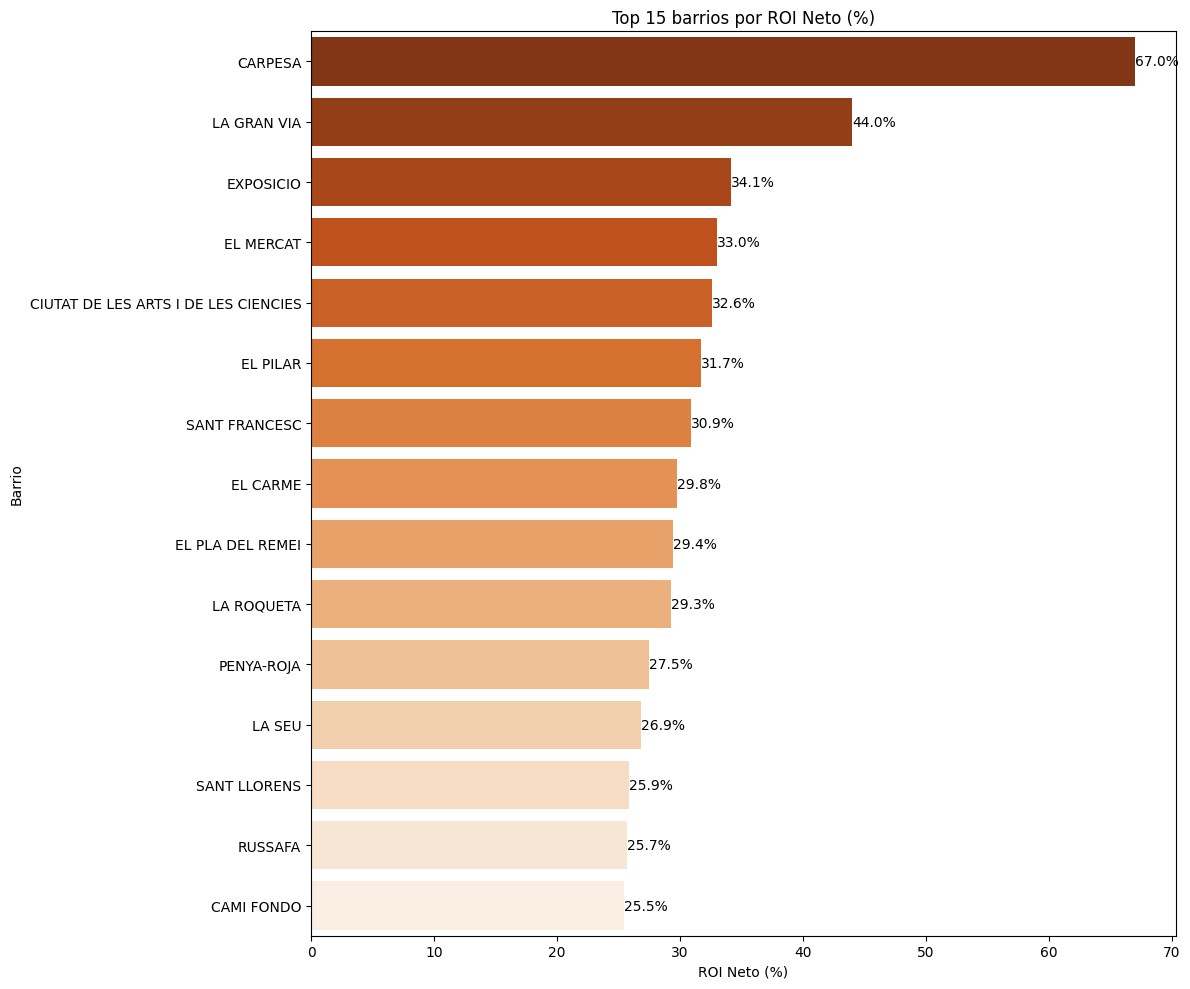

In [14]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(
    y=roi_por_barrio.index[:15], 
    x=roi_por_barrio['Net ROI (%)'][:15], 
    palette='Oranges_r'
)
plt.title("Top 15 barrios por ROI Neto (%)")
plt.xlabel("ROI Neto (%)")
plt.ylabel("Barrio")
plt.tight_layout()

# Añadir etiquetas de porcentaje en cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.show()

Conclusión: 

El gráfico muestra los 15 barrios de Valencia con mayor retorno neto de la inversión (ROI Neto) en alquileres turísticos. Se observa que existen diferencias significativas entre barrios, destacando especialmente CARPESA con un ROI neto muy superior al resto. Otros barrios céntricos y turísticos como LA GRAN VIA, EXPOSICIO y EL MERCAT también presentan retornos elevados, lo que sugiere que la ubicación sigue siendo un factor clave para la rentabilidad. En general, invertir en los barrios con mayor ROI neto puede ofrecer mejores oportunidades de rentabilidad, aunque es importante considerar otros factores como la demanda, la regulación y los posibles riesgos asociados a cada zona.

In [16]:
# Calcular pricing optimo
# Limpiar y convertir precio (si está en string con símbolos)
df['price'] = df['price'].replace('[\€,]', '', regex=True).astype(float)

# Agrupar por zona
zona_stats = df.groupby('neighborhood_overview').agg({
    'price': 'mean',
    'review_scores_value': 'mean',
    'days_rented': 'mean'
}).reset_index()

# Ajuste por factores
zona_stats['factor_demanda'] = 1 + (zona_stats['days_rented'] - zona_stats['days_rented'].mean()) / zona_stats['days_rented'].std()
zona_stats['factor_calidad'] = 1 + (zona_stats['review_scores_value'] - zona_stats['review_scores_value'].mean()) / 10

zona_stats['precio_optimo'] = zona_stats['price'] * zona_stats['factor_demanda'] * zona_stats['factor_calidad']

print(zona_stats[['neighborhood_overview', 'precio_optimo']])


                                  neighborhood_overview  precio_optimo
0     "El Botanic" is an up and coming neighbourhood...     186.774449
1     "El Botànic", in the district of Extramurs, is...     -16.450741
2     "El Botànic", in the district of Extramurs, is...      74.333787
3     * Na Robella is a quiet and safe neighborhood,...      60.258276
4     * Valencia Capital beach is located in La Malv...     155.404327
...                                                 ...            ...
2877  ✔ Patraix is an authentic spanish neighborhood...     160.630305
2878  ￼<br /><br /><br /><br />The Cabanyal neighbor...      83.401202
2879  🏙️ Overview of the Neighborhood:<br /><br />Th...     151.320858
2880  📍 Wonderful location for a quick getaway.<br /...      64.800141
2881  📍Apartamento located just 2 kms. from Plaza Ay...     132.717986

[2882 rows x 2 columns]


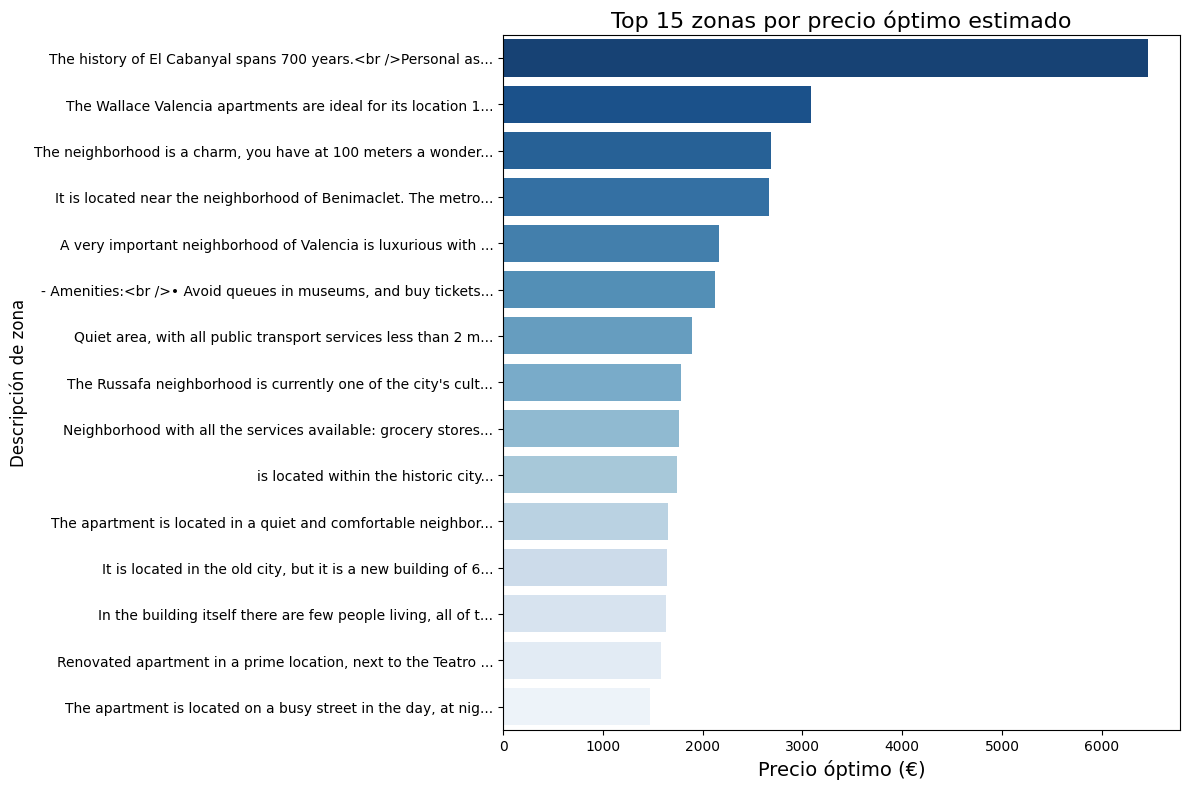

In [18]:
top_zonas = zona_stats.sort_values('precio_optimo', ascending=False).head(15)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=top_zonas['neighborhood_overview'].str.slice(0, 60) + "...",
    x=top_zonas['precio_optimo'],
    palette='Blues_r'
)
plt.title("Top 15 zonas por precio óptimo estimado", fontsize=16)
plt.xlabel("Precio óptimo (€)", fontsize=14)
plt.ylabel("Descripción de zona", fontsize=12)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
